In [23]:
class linear_regression():
    def __init__(self):
        self.X = None
        self.variables = None
        self.y = None
        self.predictor = None
        self.n = None
        self.p = None
        self.bias = None
        self.beta_hat = None
        self.y_hat = None

    # model fitting
    def fit(self, X, y, bias=True):
        self.variables = X.columns
        self.predictor = y.name
        
        X = X.to_numpy()
        y = y.to_numpy()

        if bias:
            ones_column = np.ones((X.shape[0], 1))
            X = np.append(ones_column, X, axis=1)

        self.X = X
        self.y = y
        self.n = X.shape[0]
        self.p = X.shape[1]
        self.bias = bias


        beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
        self.beta_hat = beta_hat
        self.y_hat = X @ beta_hat

    # predict new data
    def predict(self, x):
        if self.bias:
            ones_column = np.ones((x.shape[0], 1))
            x = np.append(ones_column, x, axis=1)
        return x @ self.beta_hat

    # function of sum of squared errors
    def SSE(self):
        return (self.y-self.y_hat).T@(self.y-self.y_hat)
    
    # function of mean squared errors
    def MSE(self):
        return self.SSE()/(self.n-self.p)

    # function of sum of squares regression
    def SSR(self):
        return (self.y_hat - np.mean(self.y)).T @ (self.y_hat - np.mean(self.y))

    # function of mean squared regression
    def MSR(self):
        return self.SSR()/(self.p-1)

    # function of sum of squares total
    def SST(self):
        return (self.y-np.mean(self.y_hat)).T@(self.y-np.mean(self.y_hat))

    # function of coefficient of determination
    def R_2(self):
        return 1 - self.SSE()/self.SST()

    # function of coefficient of determination on test data
    def pred_R_2(self, input, true):
        pred = self.predict(input)
        pred_SSE = (true-pred).T@(true-pred)
        pred_SST = (true-np.mean(pred)).T@(true-np.mean(pred))
        return 1 - pred_SSE/pred_SST

    # function of adjusted coefficient of determination
    def adj_R_2(self):
        return 1- (1-self.R_2())*(self.n-1)/(self.n-self.p-1)

    # function of standard deviation of coefficients
    def sd_coef(self):
        return np.sqrt(np.diagonal(self.MSE() * np.linalg.inv(self.X.T @ self.X)))

    # function of t statistic and p-value
    def t_stat(self):
        t = self.beta_hat / self.sd_coef()
        t_p = [2*(1-stats.t.cdf(np.abs(i), (self.n-self.p-1))) for i in t]
        return t, t_p

    # function of F statistic and p-value
    def F_stat(self):
        F = self.MSR()/self.MSE()
        df_1 = self.p - 1
        df_2 = self.n - self.p
        #find p-value of F test statistic 
        F_p = 1-stats.f.cdf(F, df_1, df_2) 
        return F, F_p

    # function of root mean square error
    def RMSE(self, input, true):
        pred = self.predict(input)
        return np.sqrt((true-pred).T@(true-pred)/len(true))

    # function of model summary
    def summary(self):
        coef_df = pd.DataFrame()
        
        coef_df['Estimate'] = self.beta_hat
        coef_df['Std.Error'] = self.sd_coef()
        coef_df['t value'] = self.t_stat()[0]
        coef_df['Pr(>|t|)'] = self.t_stat()[1]
        coef_df.index = ['Intercept'] + list(self.variables)

        print(coef_df)

        print(f"Residual standard error: {round(np.sqrt(self.MSE()), 3)} on {self.n-self.p} degress of freedom.")
        print(f"R-squared: {round(self.R_2(), 3)}, Adjusted R-square: {round(self.adj_R_2(), 3)}")
        f_stat_str = f"F-statistic: {round(self.F_stat()[0], 3)} on {self.p - 1} and {self.n - self.p} DF,"
        f_p_str = f"p-value: {round(self.F_stat()[1], 3)}"
        print(f_stat_str + f_p_str)

In [2]:

import numpy as np
import pandas as pd
from scipy import stats
import pandas_datareader as web
import plotly.express as px
import statsmodels.api as sm
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime as dt

In [3]:
start_date = dt.datetime(2020, 1, 1)
end_date = dt.datetime(2021, 12, 31)
data = web.DataReader('005930', 'naver', start_date, end_date)

data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02,55500,56000,55000,55200,12993228
2020-01-03,56000,56600,54900,55500,15422255
2020-01-06,54900,55600,54600,55500,10278951
2020-01-07,55700,56400,55600,55800,10009778
2020-01-08,56200,57400,55900,56800,23501171


In [4]:
pip install kaleido

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install nbformat

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Note: you may need to restart the kernel to use updated packages.


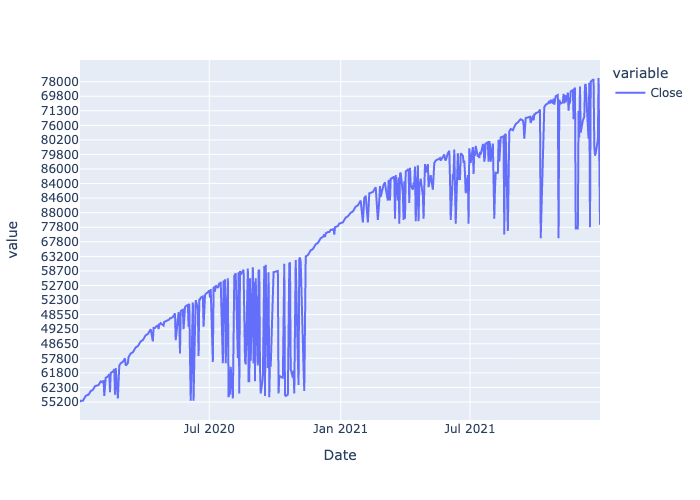

In [6]:
all_df = pd.DataFrame(data['Close'])

fig = px.line(all_df)
fig.show("png")

In [7]:
for i in range(1, 8):
    all_df[f'lag_{i}'] = all_df['Close'].shift(i)
    
all_df.head(10)

,Close,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Date,,,,,,,,
2020-01-02,55200,None,None,None,None,None,None,None
2020-01-03,55500,55200,None,None,None,None,None,None
2020-01-06,55500,55500,55200,None,None,None,None,None
2020-01-07,55800,55500,55500,55200,None,None,None,None
2020-01-08,56800,55800,55500,55500,55200,None,None,None
2020-01-09,58600,56800,55800,55500,55500,55200,None,None
2020-01-10,59500,58600,56800,55800,55500,55500,55200,None
2020-01-13,60000,59500,58600,56800,55800,55500,55500,55200
2020-01-14,60000,60000,59500,58600,56800,55800,55500,55500


In [118]:

all_df.dropna(inplace=True)
cols = [f'lag_{i}' for i in range(1, 8)]

train_df = all_df.iloc[0:181-7, :]
train_df.head(5)

,Close,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Date,,,,,,,,
2020-01-13,60000,59500,58600,56800,55800,55500,55500,55200
2020-01-14,60000,60000,59500,58600,56800,55800,55500,55500
2020-01-15,59000,60000,60000,59500,58600,56800,55800,55500
2020-01-16,60700,59000,60000,60000,59500,58600,56800,55800
2020-01-17,61300,60700,59000,60000,60000,59500,58600,56800


In [119]:
X = train_df[cols]
y = train_df['Close']

In [120]:
model = linear_regression()
X = X.astype('int')
y = y.astype('int')
model.fit(X, y)

In [121]:
model.summary()

              Estimate    Std.Error    t value  Pr(>|t|)
Intercept  1845.030954  1126.527535   1.637804  0.103368
lag_1         0.955705     0.077487  12.333730  0.000000
lag_2         0.164569     0.107159   1.535745  0.126516
lag_3        -0.193021     0.108031  -1.786721  0.075819
lag_4        -0.008526     0.109183  -0.078087  0.937853
lag_5         0.039761     0.108255   0.367293  0.713871
lag_6         0.013934     0.107555   0.129557  0.897075
lag_7        -0.006544     0.077741  -0.084180  0.933016
Residual standard error: 1158.059 on 166 degress of freedom.
R-squared: 0.938, Adjusted R-square: 0.935
F-statistic: 356.212 on 7 and 166 DF,p-value: 0.0


In [122]:
RMSE = model.RMSE(X, y)
print(f"The RMSE of training data is: {round(RMSE, 3)}")

The RMSE of training data is: 1131.123


In [123]:
print(train_df.dtypes)

Close    object
lag_1    object
lag_2    object
lag_3    object
lag_4    object
lag_5    object
lag_6    object
lag_7    object
dtype: object


/var/folders/87/qv3j_nd52_j7ggymlb8yrgtr0000gq/T/ipykernel_89008/3891254788.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



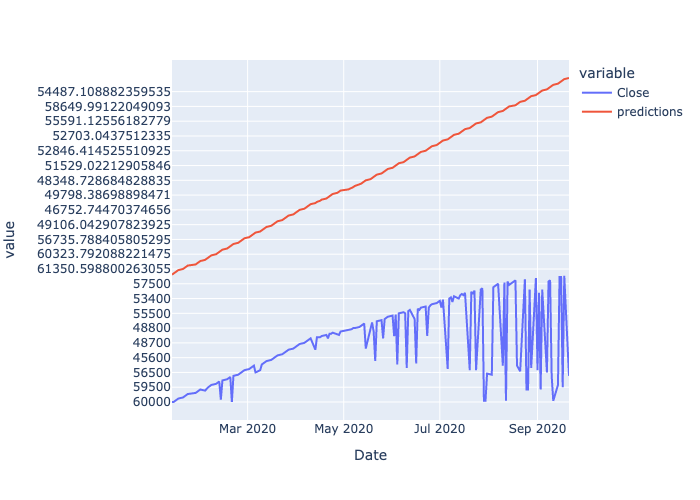

In [125]:
train_df['predictions'] = model.predict(X).astype('object')


fig = px.line(train_df, y=['Close','predictions'])


fig.show("png")

In [126]:
X_n = sm.add_constant(X)
sm.OLS(y, X_n).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     356.2
Date:                Mon, 15 Apr 2024   Prob (F-statistic):           1.74e-96
Time:                        19:36:17   Log-Likelihood:                -1470.3
No. Observations:                 174   AIC:                             2957.
Df Residuals:                     166   BIC:                             2982.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1845.0310   1126.528      1.638      0.103    -379.137    4069.199
lag_1          0.9557      0.077     12.334      0.000       0.803       1.109
lag_2          0.1646      0.107      1.536      0.127      -0.047       0.376
lag_3         -0.1930      0.108     -1.787      0.076      -0.406       0.020
lag_4         -0.0085      0.109     -0.078      0.938      -0.224       0.207
lag_5          0.0398      0.108      0.367      0.714      -0.174       0.253
lag_6          0.0139      0.108      0.130      0.897      -0.198       0.226
lag_7         -0.0065      0.078     -0.084      0.933      -0.160       0.147
==============================================================================
Omnibus:                        1.276   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.528   Jarque-Bera (JB):                0.907
Skew:                           0.066   Prob(JB):                        0.635
Kurtosis:                       3.328   Cond. No.                     1.84e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.84e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""